<a href="https://colab.research.google.com/github/vadlamani-s/Schneider/blob/main/LanguageTranslationSch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install fasttext

     |████████████████████████████████| 71kB 5.2MB/s 
  Created wheel for fasttext: filename=fasttext-0.9.2-cp36-cp36m-linux_x86_64.whl size=3040770 sha256=3422d64f0632d8b58b4f5d5a3302a7cefb6319a19f740e08745061c136490c11
  Stored in directory: /root/.cache/pip/wheels/98/ba/7f/b154944a1cf5a8cee91c154b75231136cc3a3321ab0e30f592
Successfully built fasttext


In [56]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
from keras import initializers
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import zeros
from numpy import asarray
import fasttext.util
from collections import Counter
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


Package for Language Identification


In [3]:
!wget https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin

--2020-11-23 21:23:13--  https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.75.142, 104.22.74.142, 172.67.9.4, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.75.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 131266198 (125M) [application/octet-stream]
Saving to: ‘lid.176.bin’

lid.176.bin         100%[===================>] 125.18M  50.5MB/s    in 2.5s    

2020-11-23 21:23:16 (50.5 MB/s) - ‘lid.176.bin’ saved [131266198/131266198]



In [ ]:
#!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/deu.txt

--2020-11-23 05:14:32--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/deu.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11303014 (11M) [text/plain]
Saving to: ‘deu.txt’

deu.txt             100%[===================>]  10.78M  --.-KB/s    in 0.07s   

2020-11-23 05:14:32 (153 MB/s) - ‘deu.txt’ saved [11303014/11303014]



French Word Embedding 

In [4]:
fasttext.util.download_model('fr', if_exists='ignore')
ft = fasttext.load_model('cc.fr.300.bin')

Language Translation

In [5]:
pretrained_lang_model = "lid.176.bin"
model = fasttext.load_model(pretrained_lang_model)

In [6]:
def reading_to_dataframe(file):
  df = pd.read_csv(file)
  df = df.iloc[:,2:4].dropna()
  df.reset_index(inplace=True, drop = True)
  df['message'] = df['message'].str.lower()
  df['original'] = df['original'].str.lower()
  return df

In [7]:
train_path = "/content/disaster_response_messages_training.csv"
validation_path = "/content/disaster_response_messages_validation.csv"
test_path = "/content/disaster_response_messages_test.csv"
df_train = reading_to_dataframe(train_path)
df_validation = reading_to_dataframe(validation_path)
df_test = reading_to_dataframe(test_path)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


In [8]:
df = reading_to_dataframe(train_path)
df = df.append(df_validation)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2822: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


Tokenization of the Data using Keras, removing all the punctuations

In [9]:
def tokenization(lines):
      tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
      tokenizer.fit_on_texts(lines)
      return tokenizer

In [10]:
tokenizer_message_train = tokenization(df['message'])
tokenizer_original_train = tokenization(df['original'])

In [11]:
vocabulary_size_original = len(tokenizer_original_train.word_index) + 1
vocabulary_size_message = len(tokenizer_message_train.word_index) + 1
max_original_sent_length = df['message'].str.split().str.len().max()
max_message_sent_length = df['original'].str.split().str.len().max()

In [12]:
print("Max vocabulary length of multi-lingual data :", vocabulary_size_original)
print("Max vocabulary length of english data :", vocabulary_size_message)
print("Max sentence length of multi-lingual data :", max_original_sent_length)
print("Max sentence length of english data :", max_message_sent_length)

Max vocabulary length of multi-lingual data : 15802
Max vocabulary length of english data : 10335
Max sentence length of multi-lingual data : 81
Max sentence length of english data : 60


Identification of Language

In [13]:
list_train = list()
for sentence in df_train['original']:
  list_train.append(model.predict(sentence, k = 2)[0][0])
print(Counter(list_train))

Counter({'__label__fr': 2312, '__label__tl': 1160, '__label__ht': 972, '__label__en': 881, '__label__la': 213, '__label__ro': 205, '__label__hr': 168, '__label__pl': 158, '__label__es': 150, '__label__tr': 131, '__label__de': 127, '__label__ku': 115, '__label__nl': 109, '__label__pms': 104, '__label__wa': 103, '__label__jv': 91, '__label__eo': 88, '__label__br': 87, '__label__cy': 76, '__label__it': 73, '__label__su': 64, '__label__sq': 55, '__label__vi': 55, '__label__ca': 53, '__label__id': 49, '__label__pt': 46, '__label__sw': 43, '__label__war': 41, '__label__sl': 34, '__label__ms': 24, '__label__no': 23, '__label__hu': 20, '__label__ie': 20, '__label__ceb': 19, '__label__io': 18, '__label__sh': 17, '__label__kw': 16, '__label__fi': 14, '__label__fy': 14, '__label__et': 13, '__label__mg': 12, '__label__mt': 12, '__label__gn': 11, '__label__sr': 11, '__label__sv': 11, '__label__ur': 10, '__label__cs': 10, '__label__eu': 10, '__label__bs': 9, '__label__sc': 7, '__label__cbk': 7, '__l

In [14]:
list_validation = list()
for sentence in df_validation['original']:
  list_validation.append(model.predict(sentence, k = 2)[0][0])
print(Counter(list_validation))

Counter({'__label__fr': 287, '__label__tl': 132, '__label__en': 109, '__label__ht': 106, '__label__la': 32, '__label__es': 28, '__label__ro': 24, '__label__tr': 19, '__label__ku': 17, '__label__hr': 16, '__label__pl': 16, '__label__nl': 15, '__label__de': 13, '__label__wa': 13, '__label__it': 11, '__label__su': 11, '__label__sq': 11, '__label__eo': 10, '__label__br': 10, '__label__jv': 9, '__label__pms': 8, '__label__sw': 7, '__label__no': 6, '__label__pt': 6, '__label__id': 5, '__label__sl': 5, '__label__vi': 5, '__label__ca': 5, '__label__kw': 4, '__label__cy': 3, '__label__bcl': 3, '__label__fy': 3, '__label__ms': 3, '__label__cs': 2, '__label__ur': 2, '__label__gl': 2, '__label__eml': 2, '__label__sr': 2, '__label__diq': 2, '__label__so': 1, '__label__mwl': 1, '__label__ceb': 1, '__label__sh': 1, '__label__mg': 1, '__label__cbk': 1, '__label__sc': 1, '__label__gn': 1, '__label__mt': 1, '__label__is': 1, '__label__li': 1, '__label__ilo': 1, '__label__war': 1, '__label__fi': 1, '__la

In [15]:
list_test = list()
for sentence in df_test['original']:
  list_test.append(model.predict(sentence, k = 2)[0][0])
print(Counter(list_test))

Counter({'__label__fr': 281, '__label__tl': 144, '__label__ht': 129, '__label__en': 98, '__label__la': 37, '__label__es': 30, '__label__ro': 25, '__label__hr': 24, '__label__de': 20, '__label__nl': 19, '__label__ku': 14, '__label__br': 14, '__label__pms': 12, '__label__wa': 11, '__label__eo': 11, '__label__su': 11, '__label__pl': 10, '__label__ca': 10, '__label__jv': 9, '__label__tr': 8, '__label__war': 7, '__label__sq': 7, '__label__it': 6, '__label__sw': 5, '__label__id': 5, '__label__vi': 4, '__label__sl': 4, '__label__cy': 4, '__label__ms': 3, '__label__ceb': 3, '__label__oc': 3, '__label__ie': 3, '__label__no': 3, '__label__fi': 3, '__label__gu': 2, '__label__gv': 2, '__label__pt': 2, '__label__gn': 2, '__label__eu': 2, '__label__hu': 2, '__label__fy': 1, '__label__ilo': 1, '__label__tk': 1, '__label__sh': 1, '__label__mg': 1, '__label__sco': 1, '__label__yo': 1, '__label__nds': 1, '__label__bs': 1, '__label__lmo': 1, '__label__mt': 1, '__label__mrj': 1, '__label__qu': 1, '__label

Since, the highest number of sentences in the training, validation and test set are in the French language, I will using French emebedding for Language translation.

In [70]:
df_train['label'] = list_train
df_validation['label'] = list_validation
df_test['label'] = list_test

Encoding sequences and padding with zero's

---

In [16]:
def encode_sequences(tokenizer, max_length, sentences):
  seq = tokenizer.texts_to_sequences(sentences)
  seq = pad_sequences(seq, maxlen=max_length, padding='post')
  return seq

In [17]:
encode_message = encode_sequences(tokenizer_message_train, max_message_sent_length, df_train['message'])
encode_original = encode_sequences(tokenizer_original_train, max_original_sent_length, df_train['original'])
encode_message_validate = encode_sequences(tokenizer_message_train, max_message_sent_length, df_validation['message'])
encode_original_validate = encode_sequences(tokenizer_original_train, max_original_sent_length, df_validation['original'])

In [18]:
def encode_output(sequences, vocab_size):
	ylist = list()
	for sequence in sequences:
		encoded = to_categorical(sequence, num_classes=vocab_size)
		ylist.append(encoded)
	y = array(ylist)
	y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
	return y

In [ ]:
#encode_message_validate = encode_output(encode_message_validate, vocabulary_size_message)

In [ ]:
#encode_original_validate = encode_output(encode_original_validate, vocabulary_size_original)

In [19]:
encode_message.shape

(8191, 60)

In [20]:
encode_original.shape

(8191, 81)

In [21]:
print(encode_message_validate.shape)
print(encode_original_validate.shape)

(987, 60)
(987, 81)


Building a Embedded Matrix

---



In [22]:
def create_embedded_matrix(embedding_matrix, tokenizer):
  for word, index in tokenizer.word_index.items():
    embedding_vector = ft.get_word_vector(word)
    embedding_matrix[index] = embedding_vector
  return embedding_matrix

In [23]:
embedded_matrix = zeros((vocabulary_size_original, 300))
embedded_matrix = create_embedded_matrix(embedded_matrix, tokenizer_original_train)

In [24]:
embedded_matrix.shape

(15802, 300)

In [25]:
tokenizer_original_train.word_index.items()

dict_items([('nou', 1), ('mwen', 2), ('nan', 3), ('pou', 4), ('yo', 5), ('ki', 6), ('pa', 7), ('yon', 8), ('a', 9), ('gen', 10), ('la', 11), ('se', 12), ('moun', 13), ('de', 14), ('m', 15), ('sa', 16), ('ta', 17), ('ka', 18), ('fe', 19), ('ap', 20), ('ak', 21), ('jwenn', 22), ('bezwen', 23), ('mesi', 24), ('manje', 25), ('sou', 26), ('tout', 27), ('renmen', 28), ('eske', 29), ('an', 30), ('paske', 31), ('je', 32), ('li', 33), ('dlo', 34), ('te', 35), ('si', 36), ('ou', 37), ('konnen', 38), ('ed', 39), ('e', 40), ('n', 41), ('di', 42), ('tant', 43), ('bay', 44), ('men', 45), ('svp', 46), ('kay', 47), ('kote', 48), ('ti', 49), ('tanpri', 50), ('voye', 51), ('le', 52), ('poum', 53), ('pase', 54), ('enfomasyon', 55), ('map', 56), ('anpil', 57), ('anyen', 58), ('nap', 59), ('f', 60), ('zon', 61), ('menm', 62), ('p', 63), ('mande', 64), ('d', 65), ('jwen', 66), ('ede', 67), ('ke', 68), ('s', 69), ('et', 70), ('w', 71), ('janm', 72), ('travay', 73), ('des', 74), ('kap', 75), ('ye', 76), ('les

Building the Model

---

In [26]:
model = Sequential()
embedding_dimension = 300
# embedding_layer = Embedding(vocabulary_size_original, embedding_dimension, embeddings_initializer=initializers.Constant(embedded_matrix),
#                             input_length=max_original_sent_length,trainable = False)
embedding_layer = Embedding(vocabulary_size_original, embedding_dimension, weights = [embedded_matrix], input_length=max_original_sent_length
                            , trainable = False)

In [27]:
embedding_layer.get_config()

{'activity_regularizer': None,
 'batch_input_shape': (None, 81),
 'dtype': 'float32',
 'embeddings_constraint': None,
 'embeddings_initializer': {'class_name': 'RandomUniform',
  'config': {'maxval': 0.05, 'minval': -0.05, 'seed': None}},
 'embeddings_regularizer': None,
 'input_dim': 15802,
 'input_length': 81,
 'mask_zero': False,
 'name': 'embedding',
 'output_dim': 300,
 'trainable': False}

In [28]:
units = 150
model.add(embedding_layer)
model.add(LSTM(units))
model.add(RepeatVector(max_message_sent_length))
model.add(LSTM(units, return_sequences=True))
model.add(Dense(vocabulary_size_message, activation='softmax'))
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 81, 300)           4740600   
_________________________________________________________________
lstm (LSTM)                  (None, 150)               270600    
_________________________________________________________________
repeat_vector (RepeatVector) (None, 60, 150)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 60, 150)           180600    
_________________________________________________________________
dense (Dense)                (None, 60, 10335)         1560585   
Total params: 6,752,385
Trainable params: 2,011,785
Non-trainable params: 4,740,600
_________________________________________________________________


In [30]:
import numpy as np
count = 0
weights = model.layers[0].get_weights()[0]
for i in range(model.layers[0].get_weights()[0].shape[0]):
  if np.all(weights[i]) == 0:
    count += 1
print(count)

6


In [62]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience = 20)

In [63]:
# model.fit(encode_original, encode_message, batch_size=64, validation_data=(encode_original_validate, encode_message_validate),
        # verbose = 1, callbacks = [checkpoint])
history = model.fit(encode_original, encode_message, batch_size=64,
                    validation_split = 0.2, verbose = 1, callbacks = [checkpoint, earlystopping], epochs = 100)

Epoch 1/100
102/103 [============================>.] - ETA: 0s - loss: 1.5251
Epoch 00001: val_loss improved from inf to 2.29192, saving model to model.h5
103/103 [==============================] - 10s 95ms/step - loss: 1.5253 - val_loss: 2.2919
Epoch 2/100
102/103 [============================>.] - ETA: 0s - loss: 1.5222
Epoch 00002: val_loss improved from 2.29192 to 2.27751, saving model to model.h5
103/103 [==============================] - 9s 89ms/step - loss: 1.5244 - val_loss: 2.2775
Epoch 3/100
102/103 [============================>.] - ETA: 0s - loss: 1.5196
Epoch 00003: val_loss did not improve from 2.27751
103/103 [==============================] - 9s 88ms/step - loss: 1.5188 - val_loss: 2.3002
Epoch 4/100
102/103 [============================>.] - ETA: 0s - loss: 1.5175
Epoch 00004: val_loss did not improve from 2.27751
103/103 [==============================] - 9s 89ms/step - loss: 1.5173 - val_loss: 2.2844
Epoch 5/100
102/103 [============================>.] - ETA: 0s - lo

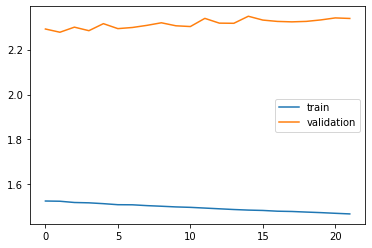

In [64]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

In [65]:
model = load_model(filename)

In [66]:
encode_original_validate[0:100]

array([[14824,    42,  1475, ...,     0,     0,     0],
       [    1,  1605,     1, ...,     0,     0,     0],
       [   29,    12,   131, ...,     0,     0,     0],
       ...,
       [   15,     7,    10, ...,     0,     0,     0],
       [    2,    23,    43, ...,     0,     0,     0],
       [    1,     3,   716, ...,     0,     0,     0]], dtype=int32)

In [67]:
prediction = model.predict_classes(encode_original_validate[:100])

In [68]:
tokenizer_message_train.word_index.items()

dict_items([('the', 1), ('i', 2), ('to', 3), ('in', 4), ('we', 5), ('a', 6), ('you', 7), ('of', 8), ('for', 9), ('are', 10), ('is', 11), ('and', 12), ('have', 13), ('help', 14), ('please', 15), ('need', 16), ('me', 17), ('can', 18), ('that', 19), ('my', 20), ('food', 21), ('like', 22), ('do', 23), ('not', 24), ('us', 25), ('what', 26), ('people', 27), ('this', 28), ('would', 29), ('know', 30), ('am', 31), ('it', 32), ('they', 33), ('on', 34), ('find', 35), ('water', 36), ('will', 37), ('if', 38), ('at', 39), ("don't", 40), ('there', 41), ('information', 42), ('because', 43), ('thank', 44), ('about', 45), ('with', 46), ('who', 47), ('no', 48), ('all', 49), ('earthquake', 50), ('how', 51), ('message', 52), ('good', 53), ('where', 54), ('be', 55), ("i'm", 56), ('some', 57), ('get', 58), ('give', 59), ('any', 60), ('from', 61), ('want', 62), ('has', 63), ('our', 64), ('send', 65), ('haiti', 66), ('your', 67), ('an', 68), ('when', 69), ('but', 70), ('house', 71), ('go', 72), ('thanks', 73),

In [78]:
def get_word(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None

predicted_text = []
for i in prediction:
       temp = []
       for j in range(len(i)):
            t = get_word(i[j], tokenizer_message_train)
            if j > 0:
                if (t == get_word(i[j-1], tokenizer_message_train)) or (t == None):
                     temp.append('')
                else:
                     temp.append(t)
            else:
                   if(t == None):
                          temp.append('')
                   else:
                          temp.append(t) 

       predicted_text.append(' '.join(temp))

In [77]:
preds_text[14]

'we are  water in                                                       '

In [72]:
df_validation[df_validation['label'] == "__label__fr"]

,message,original,label
14,"help us at delmas 65 orchidee street, we are t...",aide mous a delmas 65 rue orchidye nous avons ...,__label__fr
23,"i need water, 27 bertin street, carrefour","j ai besoin d eau 27 bertin, carrefour",__label__fr
24,overpopulation in the city of cay. there is no...,surpopulation dans la ville des cayes. pas de ...,__label__fr
25,no one can buy anything. tiny amounts of rice ...,ou paka achte anyen demi bout diri ap vann 350...,__label__fr
26,i don't know where there is a cyber cafe open....,mwen pa konnen ki cyber cafe ki ouve nou menm ...,__label__fr
...,...,...,...
961,notes: it's not important to translate,"martyre:ltils tombaient sous le fouet,perissai...",__label__fr
962,i love you and i want to work,je t'aime et je veux travailler.,__label__fr
964,i need the school help(assistant). i live in m...,j'ai besoin de l'aide scolaire. je suis mireb...,__label__fr
966,"have 100 flood effecte beleive at,ap logon ko ...","100 effecte , fl effecte! rhe likin a...",__label__fr
